# Sylhet dataset: FRS-RI and DL

In [1]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import (
    BaggingClassifier,BaggingRegressor,
    RandomForestClassifier,RandomForestRegressor,
    AdaBoostClassifier,AdaBoostRegressor,
    GradientBoostingClassifier,GradientBoostingRegressor
)

import sys

import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import time

import numpy as np 
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore') 

## Instance selection

In [2]:
MAX_INT = 10

import math
from pprint import pprint as pp
from heapq import *

class InstanceSelection:
	"""
	A class to model pipeline for selecting representative instances
	of a given dataset

	Attributes
	-----------
	dataset_matrix : a 2-D matrix of real numbers
	nrows		   : no. of rows in the dataset 
	ncols		   : no. of columns in the dataset
	fuzzy_relation_matrix : a 2-D matrix with fuzzy relation values
	lower_approx_matrix : a 1-D list of lower approximation values of each instance
	visited			: to keep track of processed instances while finding rule covering
	representative_instances_list : a list of list of representative instances of the dataset 


	Methods
	------------
	_init_params():
		Initializes various parameters

	_get_relation_value(val_i,val_j)
		Calculates fuzzy relation value  

	_is_instance_covered(row_index_i,row_index_j)
		Tells if an instance is covered by a fuzzy rule

	compute_fuzzy_relations()
		Computes fuzzy relation matrix

	compute_lower_approximation()
		Computes Lower approximation matrix

	_init_count_rule()
		Counts the number of instances covered by each rule

	find_rule_covering()
		Finds which instances are covered by which rule and
		which rules cover which instances

	find_representative_instances()
		returns a set of list of instances which are representative of the dataset

	apply()
		calls all the functions 
	"""

	def __init__(self, dataset_matrix):
		# print("Initialising instance..")
		self.dataset_matrix = dataset_matrix
		self.ncols = len(self.dataset_matrix[0])
		self.nrows = len(self.dataset_matrix)
		self.rep_list = []
		self.representative_instances_list = []
		self._init_params()

	def _init_params(self):
		# print("Initialising parameters..")
		self.fuzzy_relation_matrix = [[MAX_INT] * self.nrows for i in range(self.nrows)]
		self.rule_instances_mapping = [[] for i in range(self.nrows)]
		self.instance_rules_mapping = [[] for i in range(self.nrows)]
		self.lower_approx_matrix = [MAX_INT for i in range(self.nrows)]
		self.visited = [False]*self.nrows

	def _get_relation_value(self, vali, valj):
		return (1 - abs(vali - valj))

	def _is_instance_covered(self, row_indi, row_indj):
		if (1 - self.fuzzy_relation_matrix[row_indi][row_indj]) < self.lower_approx_matrix[row_indi]:
			return True
		return False

	def compute_fuzzy_relations(self, attr_index_list = None):
		self._init_params()
		#print("In compute_fuzzy_relations..")
		if not attr_index_list:
			attr_index_list = set(list(range(self.ncols-1)))
		for i in range(self.nrows):
			for j in range(i,self.nrows):
				for k in attr_index_list:
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = min(self.fuzzy_relation_matrix[i][j], 
								self._get_relation_value(self.dataset_matrix[i][k], self.dataset_matrix[j][k]))
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = round(self.fuzzy_relation_matrix[i][j], 2)
	
	def compute_lower_approximation(self):
		#print("In compute_lower_approximation")
		for row in range(self.nrows):
			for col in range(self.nrows):
				i_label = int(self.dataset_matrix[row][self.ncols-1])
				j_label = int(self.dataset_matrix[col][self.ncols-1])

				diff_class = 0
				if(i_label != j_label):
					diff_class = 1

				self.lower_approx_matrix[row] = min(self.lower_approx_matrix[row], max(1 - self.fuzzy_relation_matrix[row][col], 1 - diff_class))

			self.lower_approx_matrix[row] = round(self.lower_approx_matrix[row], 2)


	def _init_count_rule(self):
		self.rule_instances_count = []
		for rule in range(self.nrows):
			self.rule_instances_count.append(len(self.rule_instances_mapping[rule]))

	def find_rule_covering(self):
		# print("In find_rule_covering")
		for rowi in range(self.nrows):
			for rowj in range(self.nrows):
				if self._is_instance_covered(rowi, rowj):
					self.rule_instances_mapping[rowi].append(rowj)
					self.instance_rules_mapping[rowj].append(rowi)

		self._init_count_rule()

	def find_representative_instances(self):
		if(len(self.representative_instances_list)>0):
			return

		all_done = True
		for rule, done in enumerate(self.visited):
			if not done:
				all_done = False
				break

		if all_done:
			sorted_rep_list = sorted(self.rep_list)
			if sorted_rep_list not in self.representative_instances_list:
				self.representative_instances_list.append(sorted_rep_list)
			return

		max_count = -1

		for rule, count in enumerate(self.rule_instances_count):
			if not self.visited[rule]:
				max_count = max(max_count, count)

		max_count_list = []

		for rule, count in enumerate(self.rule_instances_count):
			if count == max_count and not self.visited[rule]:
				max_count_list.append(rule)

		for rule in max_count_list:
			self.visited[rule] = True
			self.rep_list.append(rule)
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = True

			self.find_representative_instances()
			if(len(self.representative_instances_list)>0):
				return
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = False
			self.visited[rule] = False
			self.rep_list.pop()

	def apply(self):
		self.compute_fuzzy_relations()
		self.compute_lower_approximation()
		self.find_rule_covering()
		self.find_representative_instances()
		self.visited = [False]*self.nrows
	
	def debug(self):
		pass

## Feature selection

In [3]:
class FeatureSelection:
    def __init__(self, rep_instances_set):
        self.rep_feature_set = set() 
        self.threshold = -1
        self.rep_instances_set = rep_instances_set

    def _get_instance_based_dependency_val(self, instance_selection_obj, attr_set):
        # print("ATTR SET : ",attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_fuzzy_relations(attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_lower_approximation()
        pos_sum = 0
        for instance in self.rep_instances_set:
            pos_sum += instance_selection_obj.lower_approx_matrix[instance]
        gamma_star_b = pos_sum/instance_selection_obj.nrows
        return gamma_star_b



    def find_rep_feature_set(self, instance_selection_obj):
        nattr = instance_selection_obj.ncols-1
        all_attr_set = set(list(range(nattr))) #A
        gamma_star_a = self._get_instance_based_dependency_val(instance_selection_obj, all_attr_set)
        gamma_star_a = round(gamma_star_a, 4)
        while self.threshold < gamma_star_a:
            rem_attr = all_attr_set.difference(self.rep_feature_set)
            max_gamma_star = -1
            best_attr = None
            for attr in rem_attr:
                self.rep_feature_set.add(attr)
                gamma_star = self._get_instance_based_dependency_val(instance_selection_obj, self.rep_feature_set)
                gamma_star = round(gamma_star, 4)
                # print("Gamma star : ",gamma_star,attr)
                if max_gamma_star < gamma_star and gamma_star >= self.threshold:
                    max_gamma_star = gamma_star
                    best_attr = attr
                self.rep_feature_set.discard(attr)
            if best_attr is None:
                return
            self.rep_feature_set.add(best_attr)
            # print(best_attr+1, " IS SELECTED")
            self.threshold = max_gamma_star
    
    def apply(self, instance_selection_obj):
        self.find_rep_feature_set(instance_selection_obj)

## Testing ML models

## Testing on dataset

In [4]:
import time
start_time = time.time()

In [5]:
data = pd.read_csv('diabetes_data_17features.csv',delimiter=";")
df = data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [6]:
df['class'].value_counts(normalize=True) #Class 1 means diabetic

1    0.615385
0    0.384615
Name: class, dtype: float64

In [7]:
def encoding(df):
    code = {'Female':1,
            'Male':0}
    for col in df.select_dtypes('object'):
        df.loc[:,col]=df[col].map(code)        
    return df

'''def imputation(df):
    df = df.dropna(axis=0)
    return df'''

"""def feature_engineering(df):
    useless_columns = ['patient_number']
    df = df.drop(useless_columns,axis=1)
    return df"""

def preprocessing(df):
    df = encoding(df)
    #df = feature_engineering(df)
    #df = imputation(df)
    
    X = df.drop('class',axis=1)
    y = df['class']    

    return df,X,y

In [8]:
df,_,_ = preprocessing(df)
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [9]:
# store end time
preprocess = time.time()
time_tkn1 = preprocess-start_time
print('Time taken in mins:',time_tkn1/(60))
print('Time taken in hours:',time_tkn1/(60*60))

Time taken in mins: 0.0020476182301839194
Time taken in hours: 3.412697050306532e-05


In [10]:
data = np.asarray(df)
#time_taken = {}
fsstart_time = time.time()

In [11]:
MAX_ITERATIONS = len(data)

for size in range(MAX_ITERATIONS-1,MAX_ITERATIONS):
    np.random.shuffle(data)
    test_data = data[:size]
    
    start_time1 = time.time()
    InstanceSelector = InstanceSelection(test_data)
    InstanceSelector.apply()
    end_time1 = time.time()
    algo1_time = end_time1-start_time1

    start_time2 = time.time()
    feature_selection_obj = FeatureSelection(InstanceSelector.representative_instances_list[0])
    feature_selection_obj.apply(InstanceSelector)
    end_time2 = time.time()

    representative_instances = InstanceSelector.representative_instances_list
    feature_set = list(feature_selection_obj.rep_feature_set)

In [12]:
# store end time
fs_end = time.time()
time_tkn_2 = fs_end-fsstart_time
print('Time taken in mins:',time_tkn_2/(60))
print('Time taken in hours:',time_tkn_2/(60*60))

Time taken in mins: 1.9207061449686686
Time taken in hours: 0.03201176908281114


In [13]:
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data[:,feature_set], data[:,-1], test_size=0.20, random_state=0, stratify=data[:,-1])

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
data_stn = pd.DataFrame(X_train)
data_stn.describe()

,0,1,2,3,4,5,6
count,4.160000e+02,4.160000e+02,4.160000e+02,4.160000e+02,4.160000e+02,4.160000e+02,4.160000e+02
mean,9.060594e-17,3.581537e-16,1.318390e-16,-6.111564e-17,-9.234067e-17,1.969578e-16,2.508677e-17
std,1.001204e+00,1.001204e+00,1.001204e+00,1.001204e+00,1.001204e+00,1.001204e+00,1.001204e+00
min,-2.643557e+00,-7.627248e-01,-9.809506e-01,-8.819171e-01,-9.258201e-01,-5.847525e-01,-8.949111e-01
25%,-7.584889e-01,-7.627248e-01,-9.809506e-01,-8.819171e-01,-9.258201e-01,-5.847525e-01,-8.949111e-01
50%,7.967321e-03,-7.627248e-01,-9.809506e-01,-8.819171e-01,-9.258201e-01,-5.847525e-01,-8.949111e-01
75%,7.537085e-01,1.311089e+00,1.019419e+00,1.133893e+00,1.080123e+00,1.710125e+00,1.117429e+00
max,3.488093e+00,1.311089e+00,1.019419e+00,1.133893e+00,1.080123e+00,1.710125e+00,1.117429e+00


## Creating train and test sets

In [16]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [17]:
# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim = 7, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(12, input_dim = 32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, input_dim = 12, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.00455) # initial value 0.01
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 1)

# define the grid search parameters
batch_size = [10, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)



In [18]:
# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10, return_train_score=True)
#grid_results = grid.fit(X_train, y_train)
grid_results = grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=10, epochs=10....................................
Epoch 1/10
34/34 [==============================] - 3s 3ms/step - loss: 0.6366 - accuracy: 0.6386
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 0.3210 - accuracy: 0.8855
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 0.2121 - accuracy: 0.9187
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.9337
Epoch 5/10
34/34 [==============================] - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9187
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 0.1922 - accuracy: 0.9277
Epoch 7/10
34/34 [==============================] - 0s 3ms/step - loss: 0.1894 - accuracy: 0.9367
Epoch 8/10
34/34 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9277
Epoch 9/10
34/34 [==============================] - 0s 3ms/step - loss: 0.1

34/34 [==============================] - 0s 4ms/step - loss: 0.1379 - accuracy: 0.9488
Epoch 16/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1387 - accuracy: 0.9458
Epoch 17/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.9458
Epoch 18/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.9428
Epoch 19/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1344 - accuracy: 0.9458
Epoch 20/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9458
Epoch 21/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9578
Epoch 22/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1182 - accuracy: 0.9518
Epoch 23/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1348 - accuracy: 0.9518
Epoch 24/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.9337
Epoch 25/50
34/34 [===

34/34 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9520
Epoch 45/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9550
Epoch 46/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9550
Epoch 47/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9550
Epoch 48/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1054 - accuracy: 0.9489
Epoch 49/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9459
Epoch 50/50
34/34 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9550
[CV 2/5; 2/9] END batch_size=10, epochs=50;, score=(train=0.955, test=0.964) total time=   6.2s
[CV 3/5; 2/9] START batch_size=10, epochs=50....................................
Epoch 1/50
34/34 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.7477
Epoch 2/50
34/34 [==========================

34/34 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.9189
Epoch 21/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2033 - accuracy: 0.9249
Epoch 22/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1774 - accuracy: 0.9399
Epoch 23/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.9369
Epoch 24/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.9249
Epoch 25/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9309
Epoch 26/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1812 - accuracy: 0.9339
Epoch 27/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9399
Epoch 28/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.9429
Epoch 29/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9279
Epoch 30/50
34/34 [===

34/34 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9610
Epoch 50/50
34/34 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9850
[CV 5/5; 2/9] END batch_size=10, epochs=50;, score=(train=0.985, test=0.880) total time=   6.5s
[CV 1/5; 3/9] START batch_size=10, epochs=100...................................
Epoch 1/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.8283
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 0.3096 - accuracy: 0.8855
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 0.2182 - accuracy: 0.9277
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1995 - accuracy: 0.9217
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.1944 - accuracy: 0.9337
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9247
Epoch 7/100
34/34 [========================

34/34 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9699
Epoch 78/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.9608
Epoch 79/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1300 - accuracy: 0.9578
Epoch 80/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 0.9578
Epoch 81/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9639
Epoch 82/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9669
Epoch 83/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9729
Epoch 84/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9699
Epoch 85/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0762 - accuracy: 0.9669
Epoch 86/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9518
Epoch 87/100


34/34 [==============================] - 0s 3ms/step - loss: 0.1163 - accuracy: 0.9489
Epoch 56/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9640
Epoch 57/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9640
Epoch 58/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0829 - accuracy: 0.9640
Epoch 59/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9610
Epoch 60/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0978 - accuracy: 0.9580
Epoch 61/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1012 - accuracy: 0.9489
Epoch 62/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0866 - accuracy: 0.9610
Epoch 63/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9520
Epoch 64/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9640
Epoch 65/100


34/34 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9399
Epoch 34/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.9489
Epoch 35/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9520
Epoch 36/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9459
Epoch 37/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9520
Epoch 38/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.9459
Epoch 39/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1072 - accuracy: 0.9429
Epoch 40/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1122 - accuracy: 0.9489
Epoch 41/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9520
Epoch 42/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1034 - accuracy: 0.9459
Epoch 43/100


34/34 [==============================] - 0s 3ms/step - loss: 0.1656 - accuracy: 0.9339
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1596 - accuracy: 0.9309
Epoch 13/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9309
Epoch 14/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9369
Epoch 15/100
34/34 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9309
Epoch 16/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9399
Epoch 17/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9369
Epoch 18/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.9459
Epoch 19/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1461 - accuracy: 0.9399
Epoch 20/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1405 - accuracy: 0.9369
Epoch 21/100


34/34 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9730
Epoch 94/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9640
Epoch 95/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0574 - accuracy: 0.9670
Epoch 96/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 0.9670
Epoch 97/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9700
Epoch 98/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0553 - accuracy: 0.9700
Epoch 99/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0568 - accuracy: 0.9640
Epoch 100/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0495 - accuracy: 0.9790
[CV 4/5; 3/9] END batch_size=10, epochs=100;, score=(train=0.979, test=0.928) total time=  12.2s
[CV 5/5; 3/9] START batch_size=10, epochs=100...................................
Epoch 1/100
34/34 [===============

34/34 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9850
Epoch 72/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.9730
Epoch 73/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.9820
Epoch 74/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.9760
Epoch 75/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.9760
Epoch 76/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9790
Epoch 77/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0722 - accuracy: 0.9670
Epoch 78/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9760
Epoch 79/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.9700
Epoch 80/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9730
Epoch 81/100


17/17 [==============================] - 0s 4ms/step - loss: 0.1690 - accuracy: 0.9279
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1541 - accuracy: 0.9309
[CV 4/5; 4/9] END batch_size=20, epochs=10;, score=(train=0.931, test=0.952) total time=   1.1s
[CV 5/5; 4/9] START batch_size=20, epochs=10....................................
Epoch 1/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5736
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.7988
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.3380 - accuracy: 0.9129
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9399
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1665 - accuracy: 0.9399
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9429
Epoch 7/10
17/17 [==============================]

17/17 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9369
Epoch 12/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1735 - accuracy: 0.9369
Epoch 13/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.9309
Epoch 14/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1767 - accuracy: 0.9399
Epoch 15/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9369
Epoch 16/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9489
Epoch 17/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9399
Epoch 18/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1616 - accuracy: 0.9399
Epoch 19/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9429
Epoch 20/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.9369
Epoch 21/50
17/17 [===

17/17 [==============================] - 0s 3ms/step - loss: 0.1266 - accuracy: 0.9429
Epoch 41/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1514 - accuracy: 0.9399
Epoch 42/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9399
Epoch 43/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.9369
Epoch 44/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.9489
Epoch 45/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9429
Epoch 46/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 0.9520
Epoch 47/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1128 - accuracy: 0.9489
Epoch 48/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9369
Epoch 49/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1135 - accuracy: 0.9520
Epoch 50/50
17/17 [===

17/17 [==============================] - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9550
Epoch 17/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1108 - accuracy: 0.9580
Epoch 18/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1046 - accuracy: 0.9580
Epoch 19/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1043 - accuracy: 0.9550
Epoch 20/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0994 - accuracy: 0.9550
Epoch 21/50
17/17 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9520
Epoch 22/50
17/17 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9580
Epoch 23/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9459
Epoch 24/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 0.9580
Epoch 25/50
17/17 [==============================] - 0s 4ms/step - loss: 0.1009 - accuracy: 0.9580
Epoch 26/50
17/17 [===

Epoch 45/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0934 - accuracy: 0.9548
Epoch 46/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9669
Epoch 47/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0946 - accuracy: 0.9669
Epoch 48/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9669
Epoch 49/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9699
Epoch 50/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0968 - accuracy: 0.9639
Epoch 51/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 0.9669
Epoch 52/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 0.9699
Epoch 53/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0899 - accuracy: 0.9699
Epoch 54/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9669


17/17 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9429
Epoch 24/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9429
Epoch 25/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.9339
Epoch 26/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.9399
Epoch 27/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1549 - accuracy: 0.9369
Epoch 28/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1374 - accuracy: 0.9429
Epoch 29/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1393 - accuracy: 0.9459
Epoch 30/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1474 - accuracy: 0.9429
Epoch 31/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1382 - accuracy: 0.9459
Epoch 32/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1352 - accuracy: 0.9399
Epoch 33/100


17/17 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.7718
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5841 - accuracy: 0.8559
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3934 - accuracy: 0.8979
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.2478 - accuracy: 0.9189
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.2061 - accuracy: 0.9309
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1979 - accuracy: 0.9189
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9369
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9309
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9399
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9399
Epoch 11/100
17/17 [=

17/17 [==============================] - 0s 4ms/step - loss: 0.0514 - accuracy: 0.9760
Epoch 84/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.9760
Epoch 85/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.9640
Epoch 86/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9700
Epoch 87/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0564 - accuracy: 0.9760
Epoch 88/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9760
Epoch 89/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.9760
Epoch 90/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0489 - accuracy: 0.9760
Epoch 91/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.9760
Epoch 92/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9700
Epoch 93/100


17/17 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.9610
Epoch 62/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.9670
Epoch 63/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.9580
Epoch 64/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.9640
Epoch 65/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9610
Epoch 66/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9760
Epoch 67/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.9670
Epoch 68/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9369
Epoch 69/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9580
Epoch 70/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.9640
Epoch 71/100


17/17 [==============================] - 0s 4ms/step - loss: 0.1026 - accuracy: 0.9610
Epoch 40/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.9550
Epoch 41/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1046 - accuracy: 0.9520
Epoch 42/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9550
Epoch 43/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9520
Epoch 44/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1060 - accuracy: 0.9580
Epoch 45/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9550
Epoch 46/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9550
Epoch 47/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1010 - accuracy: 0.9580
Epoch 48/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9520
Epoch 49/100


9/9 [==============================] - 0s 4ms/step - loss: 0.3505 - accuracy: 0.9039
Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2433 - accuracy: 0.9219
Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9219
Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1967 - accuracy: 0.9399
Epoch 8/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1941 - accuracy: 0.9369
Epoch 9/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1870 - accuracy: 0.9339
Epoch 10/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9369
[CV 2/5; 7/9] END batch_size=40, epochs=10;, score=(train=0.937, test=0.928) total time=   0.7s
[CV 3/5; 7/9] START batch_size=40, epochs=10....................................
Epoch 1/10
9/9 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.6126
Epoch 2/10
9/9 [==============================] - 0s 4ms/step - l

9/9 [==============================] - 0s 3ms/step - loss: 0.1279 - accuracy: 0.9578
Epoch 35/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1247 - accuracy: 0.9518
Epoch 36/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.9548
Epoch 37/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1210 - accuracy: 0.9578
Epoch 38/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9578
Epoch 39/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1320 - accuracy: 0.9548
Epoch 40/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9608
Epoch 41/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1251 - accuracy: 0.9578
Epoch 42/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9578
Epoch 43/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1401 - accuracy: 0.9428
Epoch 44/50
9/9 [=========================

9/9 [==============================] - 0s 3ms/step - loss: 0.1958 - accuracy: 0.9309
Epoch 12/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9279
Epoch 13/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1821 - accuracy: 0.9399
Epoch 14/50
9/9 [==============================] - 0s 4ms/step - loss: 0.1882 - accuracy: 0.9399
Epoch 15/50
9/9 [==============================] - 0s 4ms/step - loss: 0.1798 - accuracy: 0.9399
Epoch 16/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9339
Epoch 17/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1758 - accuracy: 0.9429
Epoch 18/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.9399
Epoch 19/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1728 - accuracy: 0.9429
Epoch 20/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9459
Epoch 21/50
9/9 [=========================

9/9 [==============================] - 0s 4ms/step - loss: 0.1073 - accuracy: 0.9520
Epoch 43/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9489
Epoch 44/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9489
Epoch 45/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1117 - accuracy: 0.9429
Epoch 46/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1114 - accuracy: 0.9520
Epoch 47/50
9/9 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9459
Epoch 48/50
9/9 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.9459
Epoch 49/50
9/9 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9489
Epoch 50/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0899 - accuracy: 0.9670
[CV 4/5; 8/9] END batch_size=40, epochs=50;, score=(train=0.967, test=0.940) total time=   2.1s
[CV 5/5; 8/9] START batch_size=40, epochs=5

9/9 [==============================] - 0s 3ms/step - loss: 0.1412 - accuracy: 0.9488
Epoch 20/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1441 - accuracy: 0.9518
Epoch 21/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.9428
Epoch 22/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1562 - accuracy: 0.9428
Epoch 23/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9518
Epoch 24/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1342 - accuracy: 0.9488
Epoch 25/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9518
Epoch 26/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9518
Epoch 27/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9548
Epoch 28/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9548
Epoch 29/100
9/9 [===============

[CV 1/5; 9/9] END batch_size=40, epochs=100;, score=(train=0.982, test=0.929) total time=   3.7s
[CV 2/5; 9/9] START batch_size=40, epochs=100...................................
Epoch 1/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6096
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6246
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5094 - accuracy: 0.8258
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.3717 - accuracy: 0.9069
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.9279
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2269 - accuracy: 0.9279
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2103 - accuracy: 0.9219
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2034 - accuracy: 0.9309
Epoch 9/100
9/9 [=============================

9/9 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.9820
Epoch 83/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0703 - accuracy: 0.9820
Epoch 84/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.9880
Epoch 85/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.9790
Epoch 86/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9670
Epoch 87/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0780 - accuracy: 0.9670
Epoch 88/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0749 - accuracy: 0.9730
Epoch 89/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.9760
Epoch 90/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9850
Epoch 91/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9730
Epoch 92/100
9/9 [===============

9/9 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9459
Epoch 63/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1318 - accuracy: 0.9520
Epoch 64/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1352 - accuracy: 0.9520
Epoch 65/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1330 - accuracy: 0.9489
Epoch 66/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9520
Epoch 67/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1273 - accuracy: 0.9489
Epoch 68/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1267 - accuracy: 0.9520
Epoch 69/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9429
Epoch 70/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9520
Epoch 71/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9429
Epoch 72/100
9/9 [===============

9/9 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9429
Epoch 43/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9429
Epoch 44/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1758 - accuracy: 0.9459
Epoch 45/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9550
Epoch 46/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.9489
Epoch 47/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9459
Epoch 48/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9489
Epoch 49/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.9520
Epoch 50/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.9489
Epoch 51/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1599 - accuracy: 0.9520
Epoch 52/100
9/9 [===============

9/9 [==============================] - 0s 3ms/step - loss: 0.2275 - accuracy: 0.9489
Epoch 23/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9489
Epoch 24/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.9489
Epoch 25/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2181 - accuracy: 0.9520
Epoch 26/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2169 - accuracy: 0.9550
Epoch 27/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9520
Epoch 28/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2104 - accuracy: 0.9550
Epoch 29/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2080 - accuracy: 0.9520
Epoch 30/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.9520
Epoch 31/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.9520
Epoch 32/100
9/9 [===============

Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.8630
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.5141 - accuracy: 0.8702
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.4364 - accuracy: 0.9135
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3567 - accuracy: 0.9351
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2650 - accuracy: 0.9375
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2076 - accuracy: 0.9351
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.9327
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1828 - accuracy: 0.9351
Epoch 11/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1783 - accuracy: 0.9351
Epoch 12/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9375
Epoch 1

Epoch 85/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9712
Epoch 86/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.9736
Epoch 87/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9736
Epoch 88/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9639
Epoch 89/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9784
Epoch 90/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9808
Epoch 91/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9856
Epoch 92/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9832
Epoch 93/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.9736
Epoch 94/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0724 - accuracy: 0.9784


In [19]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.9423408031463623, using {'batch_size': 40, 'epochs': 100}
0.9280264019966126 (0.03911645669867585) with: {'batch_size': 10, 'epochs': 10}
0.9303213000297547 (0.03516981180341419) with: {'batch_size': 10, 'epochs': 50}
0.930263900756836 (0.02688558534096548) with: {'batch_size': 10, 'epochs': 100}
0.9279116511344909 (0.02943256631164443) with: {'batch_size': 20, 'epochs': 10}
0.9207400918006897 (0.02886283713440143) with: {'batch_size': 20, 'epochs': 50}
0.9302925944328309 (0.024559117726798085) with: {'batch_size': 20, 'epochs': 100}
0.918273103237152 (0.026817570293047717) with: {'batch_size': 40, 'epochs': 10}
0.925588071346283 (0.03806412856121918) with: {'batch_size': 40, 'epochs': 50}
0.9423408031463623 (0.028831539753126717) with: {'batch_size': 40, 'epochs': 100}


In [20]:
bst_size, bst_eph = grid_results.best_params_.values()
print(bst_size, bst_eph)

40 100


In [21]:
dl_start_time = time.time()

Epoch 1/100
11/11 [==============================] - 0s 16ms/step - loss: 0.6857 - accuracy: 0.6082 - val_loss: 0.6706 - val_accuracy: 0.6154
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6447 - accuracy: 0.8654 - val_loss: 0.5901 - val_accuracy: 0.9038
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5197 - accuracy: 0.9183 - val_loss: 0.3955 - val_accuracy: 0.9038
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3200 - accuracy: 0.9255 - val_loss: 0.2251 - val_accuracy: 0.9231
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2144 - accuracy: 0.9303 - val_loss: 0.1834 - val_accuracy: 0.9231
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1971 - accuracy: 0.9351 - val_loss: 0.1757 - val_accuracy: 0.9327
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1912 - accuracy: 0.9351 - val_loss: 0.1706 - val_accuracy: 0.9327
Epoch 8/100


Epoch 59/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9736 - val_loss: 0.1494 - val_accuracy: 0.9423
Epoch 60/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1020 - accuracy: 0.9688 - val_loss: 0.1673 - val_accuracy: 0.9231
Epoch 61/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0916 - accuracy: 0.9591 - val_loss: 0.1514 - val_accuracy: 0.9423
Epoch 62/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 0.9639 - val_loss: 0.1475 - val_accuracy: 0.9519
Epoch 63/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9615 - val_loss: 0.1553 - val_accuracy: 0.9423
Epoch 64/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.9663 - val_loss: 0.1581 - val_accuracy: 0.9231
Epoch 65/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0823 - accuracy: 0.9639 - val_loss: 0.1489 - val_accuracy: 0.9519
Epoch 

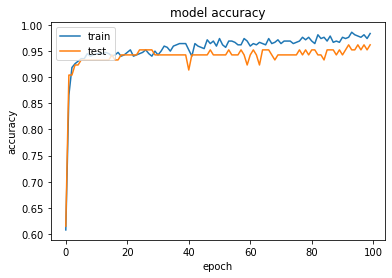

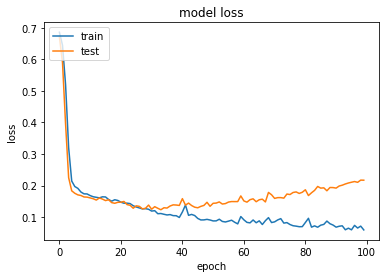

In [22]:
# call the function to fit to the data (training the network)
history= model.fit(X_train, y_train, epochs = bst_eph, batch_size=bst_size, validation_data=(X_test, y_test))

# save the model
#model.save('weights.h5')


print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
y_pred = grid.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9519230769230769
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        40
           1       0.94      0.98      0.96        64

    accuracy                           0.95       104
   macro avg       0.96      0.94      0.95       104
weighted avg       0.95      0.95      0.95       104



In [25]:
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("Recall score of the model: ", recall_score(y_test, y_pred))
print("precision of the model: ", precision_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9519230769230769
Recall score of the model:  0.984375
precision of the model:  0.9402985074626866


Text(0.5, 15.0, 'Predicted label')

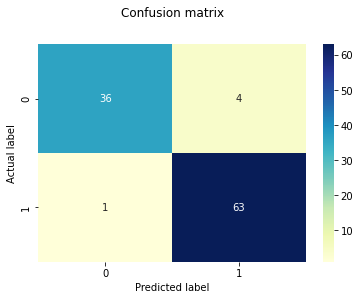

In [26]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [28]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.9421875


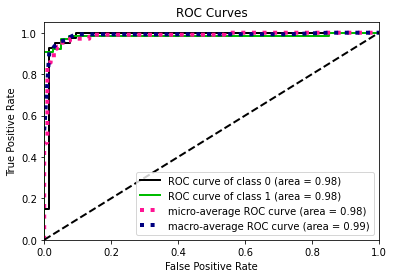

In [29]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = grid.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)

In [30]:
end = time.time()
time_tkn = end-dl_start_time
print('Time taken in hours:',time_tkn/(60*60))

Time taken in hours: 0.002228584951824612
